In [3]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
def carbon_price(p,e): #碳定价与售电功率可变
    # Load data (replace with your actual file paths)
    output_df = pd.read_csv("output.csv")

    # Constants and parameters
    M = 1e6
    T = list(range(24*9))  # Time periods



    factor_wt = output_df.iloc[T, 3].values
    factor_pv = output_df.iloc[T, 2].values
    factor_load = output_df.iloc[T, 4].values

    # Create Pyomo model
    model = pyo.ConcreteModel()

    # Time index set
    model.T = pyo.Set(initialize=T)

    # Electricity price generation (equivalent to your Julia function)
    def generate_electricity_price():
        price = [3,3,3,3,2,2,2,2,4,4,4,3,3,2,1,1,2,3,3,4,4,5,5,4]*9
        price_mapping = {1:0.1049, 2:0.1411, 3:0.3223, 4:0.5035, 5:0.5639}
        #price_mapping = {1:0.1049, 2:0.1411, 3:0.3223, 4:0.5035, 5:0.6639}
        return [price_mapping.get(p,p) for p in price]

    price = np.array(generate_electricity_price())
    price_H2 = [p/0.67 for p in price]
    price_Q = [p/4 for p in price]

    # Load calculations
    H_Load = 175 * 3.25 * factor_load
    Q_Load = (4.2*751.13 + 2.9*740.2 + 1*735.7) * factor_load
    L_Load = (31700 + 600) * factor_load

    # Variables
    model.priceH = pyo.Var(model.T,within=pyo.NonNegativeReals,bounds=(0,1))
    model.lambd = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu1 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_buy = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_ET2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_ET2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu3 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.lambd2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu4 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu5 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.Q_buy = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.Q_HP = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_HP = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu6 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.priceQ = pyo.Var(model.T, within=pyo.NonNegativeReals, bounds=(0,1))

    # Investment costs
    IC_ET2 = 5e4
    IC_HP = 2e4
    IC_ET = 13191
    IC_FC = 3233
    IC_ES = 23996
    IC_HS = 10864
    IC_WT = 55887
    IC_PV = 21272

    # Electrolyzer (ET) constraints
    model.E_ET = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_ET = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_ET_SELL = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def et_efficiency_rule(model, t):
        return model.H_ET[t] == model.E_ET[t] * 0.63#0.63
    model.et_efficiency = pyo.Constraint(model.T, rule=et_efficiency_rule)

    def et_capacity_rule(model, t):
        return model.E_ET[t] <= IC_ET
    model.et_capacity = pyo.Constraint(model.T, rule=et_capacity_rule)

    '''def et_capacity_rule2(model, t):
        return 0.1*IC_ET-model.E_ET[t] <= 0
    model.et_capacity2 = pyo.Constraint(model.T, rule=et_capacity_rule2)'''

    '''def et_ramp_up_rule(model, t):
        if t > 0:
            return model.E_ET[t] - model.E_ET[t-1] <= 0.15*IC_ET
        return pyo.Constraint.Skip
    model.et_ramp_up = pyo.Constraint(model.T, rule=et_ramp_up_rule)

    def et_ramp_down_rule(model, t):
        if t > 0:
            return model.E_ET[t] - model.E_ET[t-1] >= -0.15*IC_ET
        return pyo.Constraint.Skip
    model.et_ramp_down = pyo.Constraint(model.T, rule=et_ramp_down_rule)

    def et_min_rule(model, t):
        return model.E_ET[t] >= 0.1*IC_ET
    model.et_min = pyo.Constraint(model.T, rule=et_min_rule)'''

    def et_sell_rule(model, t):
        return model.H_ET_SELL[t] == model.H_buy[t]
    model.et_sell = pyo.Constraint(model.T, rule=et_sell_rule)

    # Fuel Cell (FC) constraints
    model.H_FC = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_FC = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.Q_FC = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_FC2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_FC2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.Q_FC2 = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def fc_efficiency_rule(model, t):
        return model.E_FC[t] == model.H_FC[t] * 0.57
    model.fc_efficiency = pyo.Constraint(model.T, rule=fc_efficiency_rule)

    def fc_heat_rule(model, t):
        return model.Q_FC[t] == model.H_FC[t] * 0.28
    model.fc_heat = pyo.Constraint(model.T, rule=fc_heat_rule)

    def fc2_efficiency_rule(model, t):
        return model.E_FC2[t] == model.H_FC2[t] * 0.57#0.57
    model.fc2_efficiency = pyo.Constraint(model.T, rule=fc2_efficiency_rule)

    def fc2_heat_rule(model, t):
        return model.Q_FC2[t] == model.H_FC2[t] * 0.28
    model.fc2_heat = pyo.Constraint(model.T, rule=fc2_heat_rule)

    def fc2_qbuy_rule(model, t):
        return model.Q_FC2[t] <= model.Q_buy[t]
    model.fc2_qbuy = pyo.Constraint(model.T, rule=fc2_qbuy_rule)

    def fc_capacity_rule(model, t):
        return model.E_FC2[t] + model.E_FC[t] <= IC_FC*0.57
    model.fc_capacity = pyo.Constraint(model.T, rule=fc_capacity_rule)

    # Electricity Storage (ES) constraints
    model.E_ES = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_ES_in = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_ES_out = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.gamma = pyo.Var(model.T, within=pyo.Binary)

    ηI_ES = 0.96
    ηO_ES = 0.96
    r_ES = 0.5
    min_ES = 0.1
    max_ES = 1.0
    ini_ES = 0.2
    loss_ES = 0.01

    def es_initial_rule(model):
        return model.E_ES[0] == ini_ES * IC_ES * (1 - loss_ES) + model.E_ES_in[0] * ηI_ES - model.E_ES_out[0] / ηO_ES
    model.es_initial = pyo.Constraint(rule=es_initial_rule)

    def es_balance_rule(model, t):
        if t > 0:
            return model.E_ES[t] == model.E_ES[t-1] * (1 - loss_ES) + model.E_ES_in[t] * ηI_ES - model.E_ES_out[t] / ηO_ES
        return pyo.Constraint.Skip
    model.es_balance = pyo.Constraint(model.T, rule=es_balance_rule)

    def es_in_limit_rule(model, t):
        return model.E_ES_in[t] <= r_ES * IC_ES
    model.es_in_limit = pyo.Constraint(model.T, rule=es_in_limit_rule)

    def es_out_limit_rule(model, t):
        return model.E_ES_out[t] <= r_ES * IC_ES
    model.es_out_limit = pyo.Constraint(model.T, rule=es_out_limit_rule)

    def es_min_rule(model, t):
        return min_ES * IC_ES <= model.E_ES[t]
    model.es_min = pyo.Constraint(model.T, rule=es_min_rule)

    def es_max_rule(model, t):
        return model.E_ES[t] <= max_ES * IC_ES
    model.es_max = pyo.Constraint(model.T, rule=es_max_rule)

    def es_final_rule(model):
        return model.E_ES[max(T)] == ini_ES * IC_ES
    model.es_final = pyo.Constraint(rule=es_final_rule)

    def es_in_bin_rule(model, t):
        return model.E_ES_in[t] <= model.gamma[t]*M
    model.es_in_bin = pyo.Constraint(model.T, rule=es_in_bin_rule)

    def es_out_bin_rule(model, t):
        return model.E_ES_out[t] <= (1-model.gamma[t])*M
    model.es_out_bin = pyo.Constraint(model.T, rule=es_out_bin_rule)

    # Hydrogen Storage (HS) constraints
    model.H_HS = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_HS_in = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_HS_out = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.gammaH=pyo.Var(model.T,within=pyo.Binary)

    ηI_HS = 0.8 #0.8
    ηO_HS = 0.8 #0.8
    r_HS = 0.25
    min_HS = 0.1
    max_HS = 1.0
    ini_HS = 0.15
    loss_HS = 0.001

    def hs_initial_rule(model):
        return model.H_HS[0] == ini_HS * IC_HS * (1 - loss_HS) + model.H_HS_in[0] * ηI_HS - model.H_HS_out[0] / ηO_HS
    model.hs_initial = pyo.Constraint(rule=hs_initial_rule)

    def hs_balance_rule(model, t):
        if t > 0:
            return model.H_HS[t] == model.H_HS[t-1] * (1 - loss_HS) + model.H_HS_in[t] * ηI_HS - model.H_HS_out[t] / ηO_HS
        return pyo.Constraint.Skip
    model.hs_balance = pyo.Constraint(model.T, rule=hs_balance_rule)

    def hs_in_limit_rule(model, t):
        return model.H_HS_in[t] <= r_HS * IC_HS
    model.hs_in_limit = pyo.Constraint(model.T, rule=hs_in_limit_rule)

    def hs_out_limit_rule(model, t):
        return model.H_HS_out[t] <= r_HS * IC_HS
    model.hs_out_limit = pyo.Constraint(model.T, rule=hs_out_limit_rule)

    def hs_min_rule(model, t):
        return min_HS * IC_HS <= model.H_HS[t]
    model.hs_min = pyo.Constraint(model.T, rule=hs_min_rule)

    def hs_max_rule(model, t):
        return model.H_HS[t] <= max_HS * IC_HS
    model.hs_max = pyo.Constraint(model.T, rule=hs_max_rule)

    def hs_final_rule(model):
        return model.H_HS[max(T)] == ini_HS * IC_HS
    model.hs_final = pyo.Constraint(rule=hs_final_rule)
    
    '''def hs_in_bin_rule(model, t):
        return model.H_HS_in[t] <= model.gammaH[t]*M
    model.hs_in_bin = pyo.Constraint(model.T, rule=hs_in_bin_rule)

    def hs_out_bin_rule(model, t):
        return model.H_HS_out[t] <= (1-model.gammaH[t])*M
    model.hs_out_bin = pyo.Constraint(model.T, rule=hs_out_bin_rule)'''

    # Wind Turbine (WT) constraints
    P_WT = IC_WT * factor_wt
    model.E_WT = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_WT_dis = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def wt_capacity_rule(model, t):
        return model.E_WT[t] <= P_WT[t]
    model.wt_capacity = pyo.Constraint(model.T, rule=wt_capacity_rule)

    def wt_balance_rule(model, t):
        return model.E_WT[t] + model.E_WT_dis[t] == P_WT[t]
    model.wt_balance = pyo.Constraint(model.T, rule=wt_balance_rule)

    # PV constraints
    P_PV = IC_PV * factor_pv
    model.E_PV = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_PV_dis = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def pv_capacity_rule(model, t):
        return model.E_PV[t] <= P_PV[t]
    model.pv_capacity = pyo.Constraint(model.T, rule=pv_capacity_rule)

    def pv_balance_rule(model, t):
        return model.E_PV[t] + model.E_PV_dis[t] == P_PV[t]
    model.pv_balance = pyo.Constraint(model.T, rule=pv_balance_rule)

    # Market interactions
    model.E_BUY = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_SELL = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def sell_limit_rule(model, t):
        return model.E_SELL[t] <= (L_Load[t] + model.E_ET2[t] + model.E_HP[t]) * e
    def sell_limit_rule2(model, t):
        return model.E_SELL[t] <= (L_Load[t]) * 0.2
    def sell_limit_rule3(model, t):
        return model.E_SELL[t]-model.E_FC2[t] <= (L_Load[t] + model.E_ET2[t] + model.E_HP[t]) * 0.2
    model.sell_limit = pyo.Constraint(model.T, rule=sell_limit_rule)

    # Power balance constraints
    def power_balance_rule(model, t):
        return (model.E_WT[t] + model.E_PV[t] + model.E_BUY[t] + model.E_FC[t] + 
                model.E_FC2[t] + model.E_ES_out[t] == 
                model.E_ET[t] + model.E_ES_in[t] + model.E_SELL[t])
    def power_balance_rule2(model, t):
        return (model.E_WT[t] + model.E_PV[t] + model.E_BUY[t]  + model.E_ES_out[t] == 
                model.E_ET[t] + model.E_ES_in[t] + model.E_SELL[t])
    def power_balance_rule3(model, t):
        return (model.E_WT[t] + model.E_PV[t] + model.E_BUY[t] + model.E_FC[t] + 
                model.E_FC2[t] + model.E_ES_out[t] >= 
                model.E_ET[t] + model.E_ES_in[t] + model.E_SELL[t])
    model.power_balance = pyo.Constraint(model.T, rule=power_balance_rule)

    def hydrogen_balance_rule(model, t):
        return model.H_ET[t] + model.H_HS_out[t] == (model.H_FC[t] + model.H_FC2[t] + 
                                                model.H_HS_in[t] + model.H_ET_SELL[t])
    model.hydrogen_balance = pyo.Constraint(model.T, rule=hydrogen_balance_rule)

    # KKT conditions for ET2
    model.gamma1 = pyo.Var(model.T, within=pyo.Binary)
    model.gamma2 = pyo.Var(model.T, within=pyo.Binary)
    model.gamma3 = pyo.Var(model.T, within=pyo.Binary)

    def kkt1_rule(model, t):
        return price[t] + p - model.lambd[t]*0.71 - model.mu1[t] + model.mu3[t] == 0
    model.kkt1 = pyo.Constraint(model.T, rule=kkt1_rule)

    def kkt2_rule(model, t):
        return model.priceH[t] - model.lambd[t] - model.mu2[t] == 0
    model.kkt2 = pyo.Constraint(model.T, rule=kkt2_rule)

    def mu1_bin_rule(model, t):
        return model.mu1[t] <= (1-model.gamma1[t])*M
    model.mu1_bin = pyo.Constraint(model.T, rule=mu1_bin_rule)

    def et2_bin_rule(model, t):
        return model.E_ET2[t] <= model.gamma1[t]*M
    model.et2_bin = pyo.Constraint(model.T, rule=et2_bin_rule)

    def mu2_bin_rule(model, t):
        return model.mu2[t] <= (1-model.gamma2[t])*M
    model.mu2_bin = pyo.Constraint(model.T, rule=mu2_bin_rule)

    def hbuy_bin_rule(model, t):
        return model.H_buy[t] <= model.gamma2[t]*M
    model.hbuy_bin = pyo.Constraint(model.T, rule=hbuy_bin_rule)

    def et2_h_rule(model, t):
        return model.H_ET2[t] == 0.71 * model.E_ET2[t]
    model.et2_h = pyo.Constraint(model.T, rule=et2_h_rule)

    def h_load_rule(model, t):
        return model.H_buy[t] + model.H_ET2[t] == H_Load[t]
    model.h_load = pyo.Constraint(model.T, rule=h_load_rule)

    def mu3_bin_rule(model, t):
        return model.mu3[t] <= (1-model.gamma3[t])*M
    model.mu3_bin = pyo.Constraint(model.T, rule=mu3_bin_rule)

    def et2_cap_bin_rule(model, t):
        return IC_ET2 - model.E_ET2[t] <= model.gamma3[t]*M
    model.et2_cap_bin = pyo.Constraint(model.T, rule=et2_cap_bin_rule)

    # KKT conditions for HP
    model.gamma4 = pyo.Var(model.T, within=pyo.Binary)
    model.gamma5 = pyo.Var(model.T, within=pyo.Binary)
    model.gamma6 = pyo.Var(model.T, within=pyo.Binary)

    def kkt3_rule(model, t):
        return price[t] + p - model.lambd2[t]*4 - model.mu4[t] + model.mu6[t] == 0
    model.kkt3 = pyo.Constraint(model.T, rule=kkt3_rule)

    def kkt4_rule(model, t):
        return model.priceQ[t] - model.lambd2[t] - model.mu5[t] == 0
    model.kkt4 = pyo.Constraint(model.T, rule=kkt4_rule)

    def mu4_bin_rule(model, t):
        return model.mu4[t] <= (1-model.gamma4[t])*M
    model.mu4_bin = pyo.Constraint(model.T, rule=mu4_bin_rule)

    def hp_bin_rule(model, t):
        return model.E_HP[t] <= model.gamma4[t]*M
    model.hp_bin = pyo.Constraint(model.T, rule=hp_bin_rule)

    def mu5_bin_rule(model, t):
        return model.mu5[t] <= (1-model.gamma5[t])*M
    model.mu5_bin = pyo.Constraint(model.T, rule=mu5_bin_rule)

    def qbuy_bin_rule(model, t):
        return model.Q_buy[t] <= model.gamma5[t]*M
    model.qbuy_bin = pyo.Constraint(model.T, rule=qbuy_bin_rule)

    def hp_q_rule(model, t):
        return model.Q_HP[t] == 4 * model.E_HP[t]
    model.hp_q = pyo.Constraint(model.T, rule=hp_q_rule)

    def q_load_rule(model, t):
        return model.Q_buy[t] + model.Q_HP[t] == Q_Load[t]
    model.q_load = pyo.Constraint(model.T, rule=q_load_rule)

    def mu6_bin_rule(model, t):
        return model.mu6[t] <= (1-model.gamma6[t])*M
    model.mu6_bin = pyo.Constraint(model.T, rule=mu6_bin_rule)

    def hp_cap_bin_rule(model, t):
        return IC_HP - model.E_HP[t] <= model.gamma6[t]*M
    model.hp_cap_bin = pyo.Constraint(model.T, rule=hp_cap_bin_rule)

    # Objective function
    def objective_rule(model):
        return (sum(model.E_SELL[t] * price[t]*0.95 for t in model.T) + 
                sum(model.H_ET_SELL[t] * model.priceH[t] for t in model.T) - 
                sum(price[t] * model.E_BUY[t] for t in model.T))
    def objective_rule2(model):
        return (sum(model.E_SELL[t] * price[t]*0.95 for t in model.T) + 
                sum(model.H_ET_SELL[t] * model.priceH[t] for t in model.T) - 
                sum((price[t]+p) * model.E_BUY[t] for t in model.T)+sum(model.Q_FC2[t]*model.priceQ[t] for t in model.T))
    def objective_rule3(model):
        return (sum(model.E_SELL[t] * price[t]*0.95 for t in model.T) + 
                sum(model.H_ET_SELL[t] * model.priceH[t] for t in model.T) - 
                sum((price[t]+p) * model.E_BUY[t] for t in model.T)+sum(model.Q_FC2[t]*model.priceQ[t] for t in model.T)+sum(model.E_FC2[t]*price[t]*0.95 for t in model.T))
    def objective_rule4(model):
        return (sum(model.E_SELL[t] * (price[t]-0.05) for t in model.T) + 
                sum(model.H_ET_SELL[t] * model.priceH[t] for t in model.T) - 
                sum((price[t]+p) * model.E_BUY[t] for t in model.T)+sum(model.Q_FC2[t]*model.priceQ[t] for t in model.T))
    model.objective = pyo.Objective(rule=objective_rule2, sense=pyo.maximize)

    # Solve the model
    solver = pyo.SolverFactory('gurobi')  # or 'ipopt' for nonlinear problems
    solver.options['TimeLimit'] = 50
    solver.options['MIPGap'] = 0.01
    results = solver.solve(model, tee=False)

    # Print results
    print("Solver status:", results.solver.status)
    print("Termination condition:", results.solver.termination_condition)

    # Post-processing (similar to your Julia code)
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        wt_v=[pyo.value(model.E_WT[t]) for t in model.T]
        pv_v=[pyo.value(model.E_PV[t]) for t in model.T]
        buy_v=[pyo.value(model.E_BUY[t]) for t in model.T]
        fc_v=[pyo.value(model.E_FC2[t]) for t in model.T]
        es_out_v=[pyo.value(model.E_ES_out[t]) for t in model.T]
        et_v=[-pyo.value(model.E_ET[t]) for t in model.T]
        es_in_v=[-pyo.value(model.E_ES_in[t]) for t in model.T]
        sell_v=[-pyo.value(model.E_SELL[t]) for t in model.T]
        data=np.vstack([wt_v,pv_v,buy_v,fc_v,es_out_v,et_v,es_in_v,sell_v])
        np.savetxt("ebalance.csv",data.T,delimiter=",")
        #model.H_ET[t] + model.H_HS_out[t] == (model.H_FC[t] + model.H_FC2[t] + 
                                                #model.H_HS_in[t] + model.H_ET_SELL[t]
        et_h_v=[pyo.value(model.H_ET[t]) for t in model.T]
        hs_out_v=[pyo.value(model.H_HS_out[t]) for t in model.T]
        h_fc_v=[-pyo.value(model.H_FC2[t]+model.H_FC[t]) for t in model.T]
        h_sell_v=[-pyo.value(model.H_ET_SELL[t]) for t in model.T]
        hs_in_v=[-pyo.value(model.H_HS_in[t]) for t in model.T]
        data2=np.vstack([et_h_v,hs_out_v,h_fc_v,h_sell_v,hs_in_v])
        np.savetxt("hbalance.csv",data2.T,delimiter=",")
        et = [-pyo.value(model.E_ET[t])/IC_ET for t in model.T]
        fc = [-pyo.value(model.E_FC2[t]+model.E_FC[t])/IC_FC for t in model.T]
        es = [pyo.value(model.E_ES[t])/IC_ES for t in model.T]
        hs = [pyo.value(model.H_HS[t])/IC_HS for t in model.T]
        sell = [pyo.value(model.E_SELL[t])/1e5 for t in model.T]
        buy = [pyo.value(model.E_BUY[t])/1e6 for t in model.T]
        Hbuy=[pyo.value(model.H_buy[t]) for t in model.T]
        re = [(pyo.value(model.E_WT[t]) + pyo.value(model.E_PV[t]))/(IC_PV+IC_WT) for t in model.T]
        H2 = [pyo.value(model.H_ET_SELL[t])/H_Load[t] for t in model.T]
        dis = [(pyo.value(model.E_PV_dis[t]) + pyo.value(model.E_WT_dis[t])) for t in model.T]
        output=P_PV+P_WT
        priceQ=[pyo.value(model.priceQ[t])for t in model.T]
        priceH=[pyo.value(model.priceH[t])for t in model.T]
        priceH=np.array(priceH)*3.25/0.089
        priceH2=np.array(price)/0.63*3.25/0.089
        rewardE=[(pyo.value(model.E_SELL[t] * price[t]*0.95))for t in model.T]
        rewardH=[(pyo.value(model.H_ET_SELL[t] * model.priceH[t])) for t in model.T]
        rewardQ=[(pyo.value(model.Q_FC2[t]*model.priceQ[t])) for t in model.T]
        reward2=[sum(rewardE),sum(rewardH),sum(rewardQ)]
        dis_real=sum(dis)/sum(output)
        green_H2=sum(H2*H_Load)/sum(H_Load)
        reward=pyo.value(model.objective)/9
        buy_ratio=sum(buy)*1e6/(sum(buy)*1e6+sum(output))
        c=["#488820FF", "#207890FF", "#7868C0FF", "#C03000FF", "#F09008FF", "#686868FF"]
        plt.rcParams['font.sans-serif'] = ['Songti SC']  # Linux 常用
        plt.rcParams['axes.unicode_minus'] = False 
        plt.figure(figsize=(18,8),dpi=300)
        plt.plot(et, label="电解槽",color=c[0])
        plt.bar(range(len(re)),fc, label="燃料电池",color=c[4])
        plt.plot(es, label="储能",color=c[2])
        plt.plot(hs, label="储氢",color=c[3])
        plt.bar(range(len(re)), re, label="风光出力", alpha=0.6,color=c[1])
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=24)
        plt.xlabel("时间/h",fontsize=26)
        plt.ylabel("各运行参数相对值",fontsize=26)
        plt.tick_params(labelsize=22)
        plt.show()
        plt.figure(figsize=(8,6),dpi=300)
        plt.plot(priceH/35,label="氢气价格")
        #plt.plot(priceH2,label='厂商自制氢价格曲线')
        plt.xlabel("时间/h",fontsize=16)
        plt.plot(np.array(Hbuy)/6000,label="氢气购买量",alpha=0.6)
        plt.ylabel("相对值",fontsize=16)
        plt.tick_params(labelsize=14)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=14)
        cashflow=[]
        inv1=IC_ET * 6000 +  IC_FC * 8000 + IC_ES * 2000 + IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500
        cashflow.append(-inv1)
        cOM=IC_ET * 6000*0.035+IC_FC * 8000*0.035+IC_ES * 2000*0.025+IC_HS * 4000*0.015+(IC_WT * 4300 + IC_PV * 3500)*0.01
        cOM2=IC_ET*26+IC_FC*26+IC_ES*26+IC_HS*26+IC_PV*26+IC_PV*14
        depreciation=(IC_ET * 6000*2 +  IC_FC * 8000 + IC_ES * 2000*2 + IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)/20
        inv2=0
        for i in range(0,10):
            inv=(IC_ET * 6000 +IC_ES * 2000)*(10-i)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-i)/20
            inv2+=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(i+1))
            temp=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
            cashflow.append(temp)
        inv=(IC_ET * 6000 +IC_ES * 2000)*(19-10)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-10)/20
        temp=(reward*365-(IC_ET * 6000 +IC_ES * 2000)-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
        cashflow.append(temp)
        inv2+=(reward*365-(IC_ET * 6000 +IC_ES * 2000)-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(10+1))
        for i in range(11,20):
            inv=(IC_ET * 6000 +IC_ES * 2000)*(19-i)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-i)/20
            inv2+=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(i+1))
            temp=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
            cashflow.append(temp)
        irr=npf.irr(cashflow)
        plt.figure(figsize=(4,3))
        patches, texts, autotexts=plt.pie(reward2,labels=["售电收入","售氢收入","售热收入"],autopct='%1.3f%%',pctdistance=0.6)
        # 设置百分比文字样式
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(12)
            autotext.set_weight('bold')

        # 添加图例
        plt.legend(
            patches, 
            ["售电收入","售氢收入","售热收入"], 
            loc="best",  # 自动选择最佳位置
            bbox_to_anchor=(1, 0.5, 0.5, 0.5)  # 图例位置微调
            )

        # 设置标题
        plt.title('日营收组成', fontsize=16, pad=20)

        # 保证图形是正圆形
        plt.axis('equal')

        # 显示图形
        plt.tight_layout()
        plt.show()
        print(dis_real,green_H2,reward,inv2-inv1,irr,buy_ratio)

Solver status: ok
Termination condition: optimal


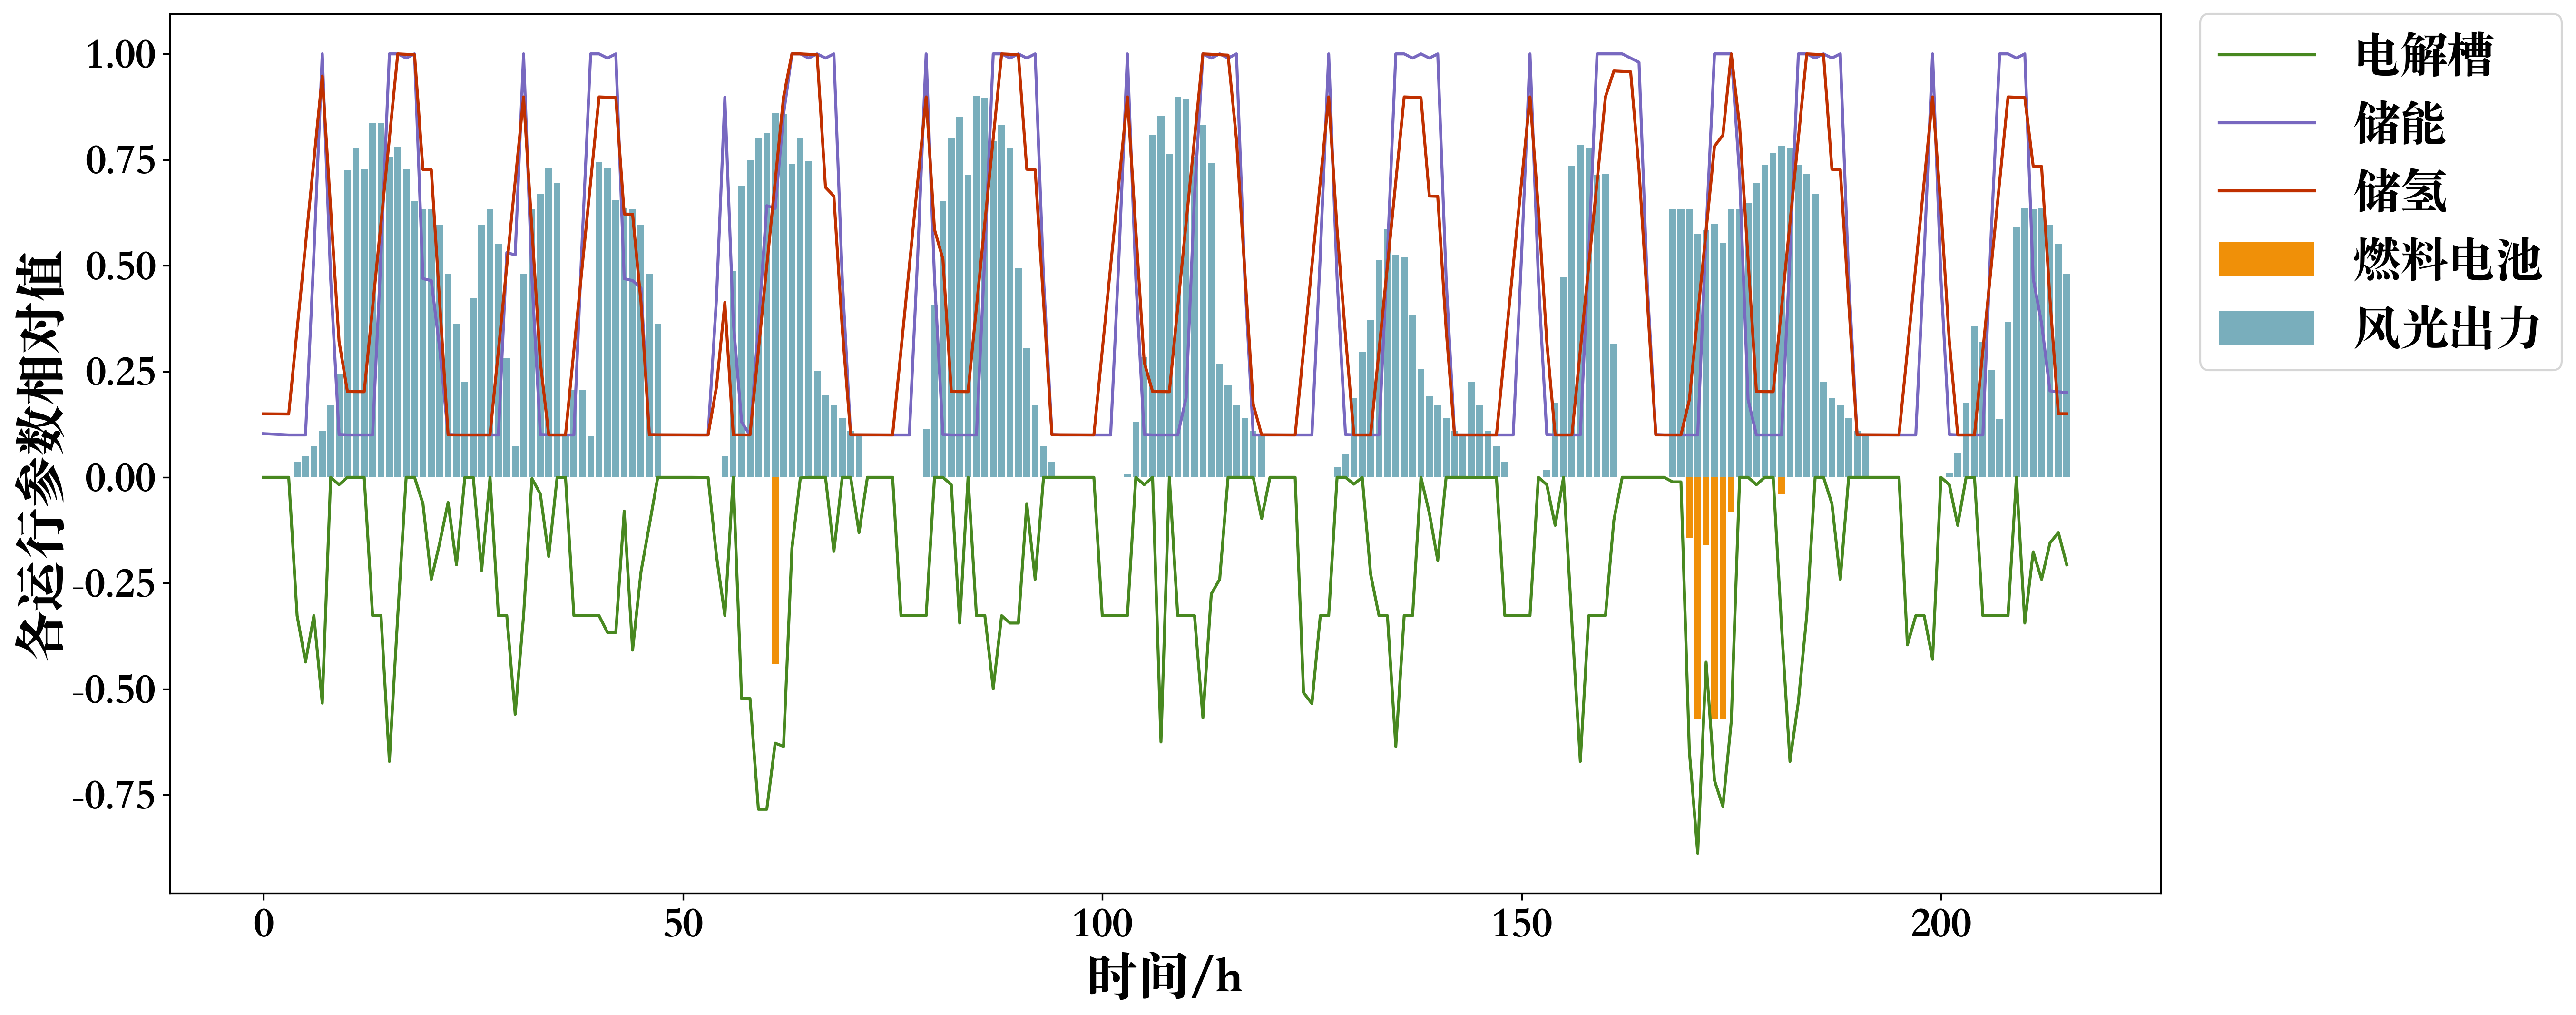

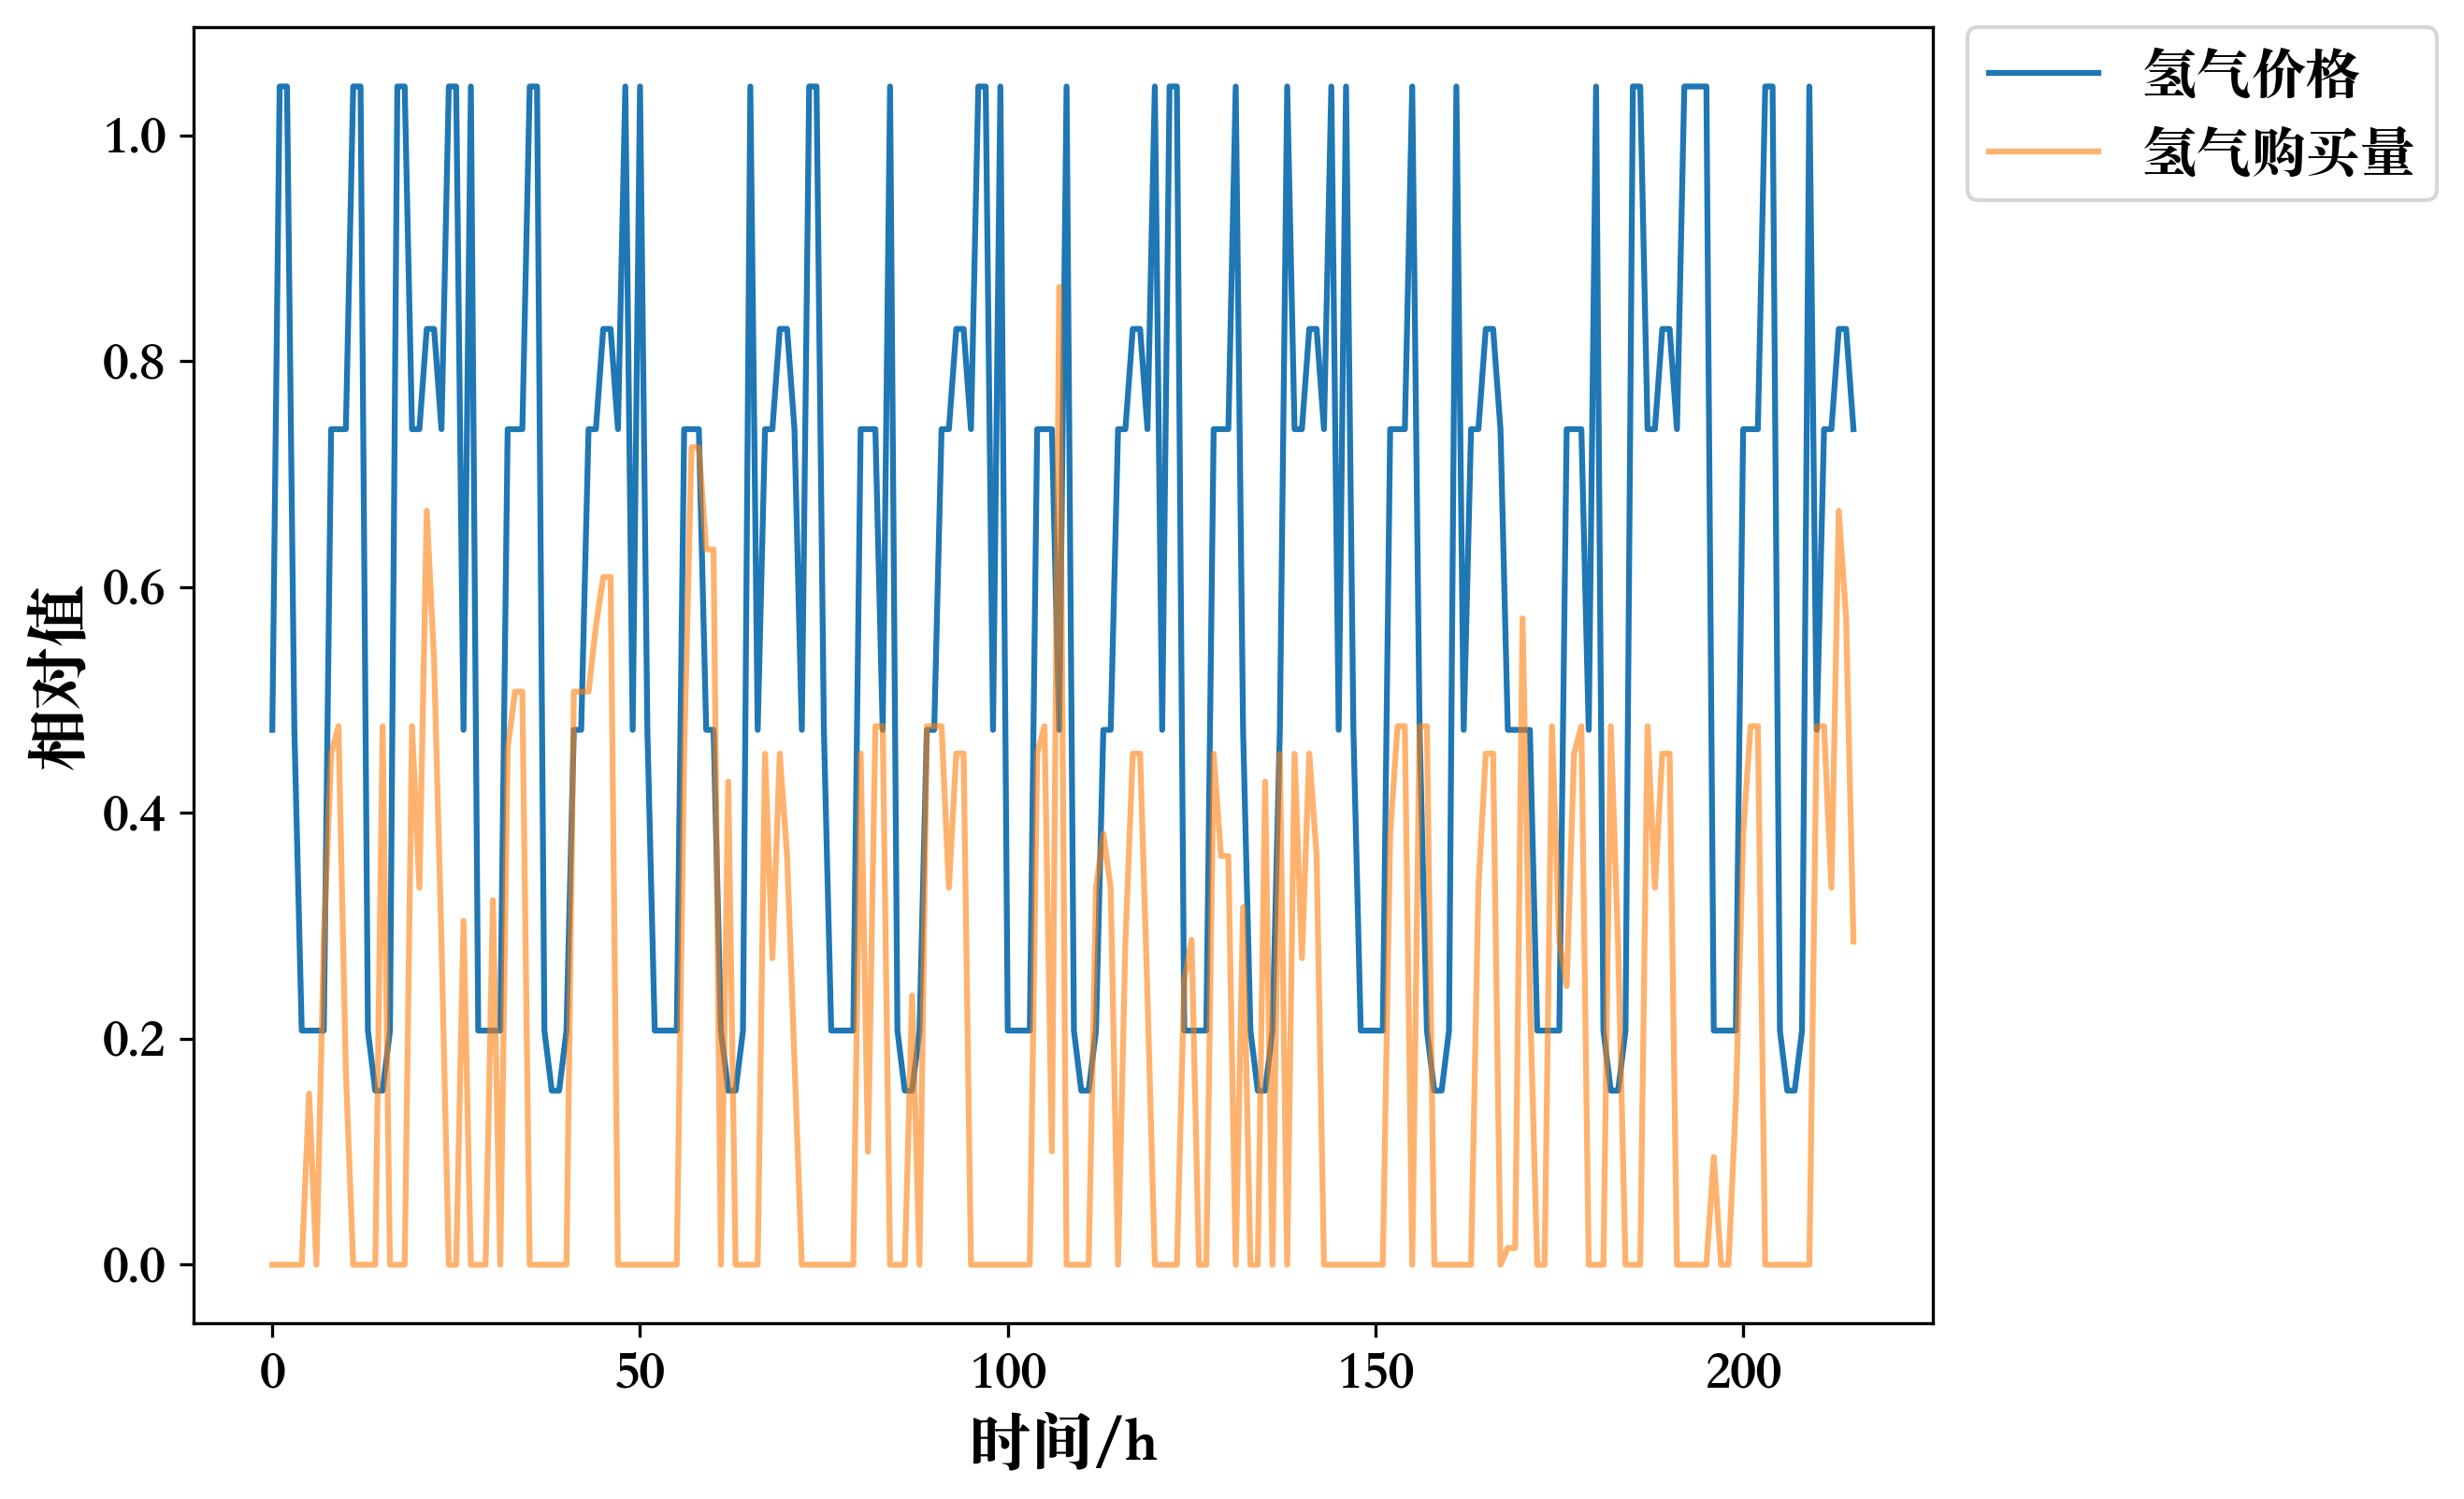

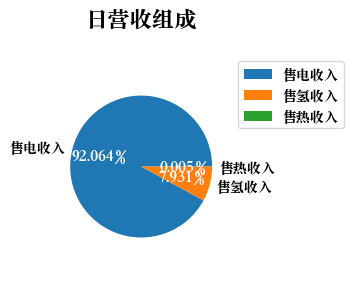

0.002981836561387131 0.2591990331421685 207588.21946032904 131753101.5451088 0.09116128934105916 0.04195429176735578


In [4]:
carbon_price(0,0.2)